## Setup

In [1]:
# install AIMNet2
!git clone https://github.com/isayevlab/AIMNet2.git
%cd AIMNet2
!pip install .

Cloning into 'AIMNet2'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 171 (delta 50), reused 34 (delta 34), pack-reused 93 (from 1)
Receiving objects: 100% (171/171), 74.31 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/AIMNet2
Processing /content/AIMNet2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211

In [3]:
# install ML-FSM
%cd
!git clone https://github.com/jonmarks12/ML-FSM
%cd ML-FSM
!pip install .

/root
Cloning into 'ML-FSM'...
remote: Enumerating objects: 504, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 504 (delta 106), reused 144 (delta 68), pack-reused 295 (from 1)
Receiving objects: 100% (504/504), 13.94 MiB | 32.75 MiB/s, done.
Resolving deltas: 100% (240/240), done.
/root/ML-FSM
Processing /root/ML-FSM
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mlfsm: filename=mlfsm-0.0.1-py3-none-any.whl size=17852 sha256=1d99393d78a9c430203b6a9b3de84c5aea3a89a15de7ebf81443ea987fe6f7c8
  Stored in directory: /root/.cache/pip/wheels/ab/b2/98/7a578b849139742dc31ebda664523cc3bfc550f3d5a709da0c
  Created wheel for geometric: filename=geometric-1.1-py3-none-any.whl size=402087 sha256=d47438

In [12]:
# Other Dependencies
!pip install matplotlib py3Dmol ipython

In [4]:
import shutil
from pathlib import Path

import ase
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
from IPython.display import HTML

from mlfsm.cos import FreezingString
from mlfsm.geom import calculate_arc_length, project_trans_rot
from mlfsm.opt import CartesianOptimizer
from mlfsm.utils import load_xyz

## Load reactant and product

In [5]:
# Mannualy
reactant = ase.Atoms(
    symbols=["C", "C", "H", "H", "H", "H", "H", "H"],
    positions=[
        [-0.7630691361, -0.0020190208, 0.0034566355],
        [0.7626325757, 0.0019950530, 0.0009730411],
        [-1.1589043116, -0.5118960388, 0.8883793728],
        [1.1613211937, 0.5116793524, 0.8847263259],
        [-1.1629572511, 1.0174805269, 0.0041985317],
        [-1.1617577754, -0.5117033851, -0.8802966057],
        [1.1625206820, -1.0175044968, 0.0002310876],
        [1.1584677813, 0.5118721300, -0.8839496535],
    ],
)
product = ase.Atoms(
    symbols=["C", "C", "H", "H", "H", "H", "H", "H"],
    positions=[
        [0.8250132507, -0.3044255156, -0.0001793369],
        [-0.0708590455, 0.6761106267, -0.0016038483],
        [-2.2168320223, -1.1357962646, 0.0051867426],
        [-2.9069107362, -1.4149124935, 0.0006665373],
        [1.2144012074, -0.7244594455, -0.9242788205],
        [1.2098231719, -0.7260043834, 0.9251338654],
        [-0.4588134959, 1.0959757755, 0.9230324730],
        [-0.4554227885, 1.0988459975, -0.9270321510],
    ],
)
# Align product to reactant structure
_, aligned_product = project_trans_rot(reactant.get_positions(), product.get_positions())
product.set_positions(aligned_product.reshape(-1, 3))

In [7]:
# From benchmark set with helper function
reactant, product = load_xyz("examples/data/06_diels_alder/")

# Run FSM

In [8]:
from aimnet2calc import AIMNet2ASE

# Parameters
nnodes_min = 18
interp = "ric"
ninterp = 50
method = "L-BFGS-B"
maxiter = 1
maxls = 3
dmax = 0.3

outdir = Path(f"FSM_run_Nodes_{nnodes_min}_interp_{interp}_maxiter_{maxiter}_maxls_{maxls}")
if outdir.exists():
    shutil.rmtree(outdir)
outdir.mkdir()

# Load calculator
chg = 0
mult = 1
calc = AIMNet2ASE("aimnet2", charge=chg, mult=mult)

# Initialize string and optimizer
string = FreezingString(reactant, product, nnodes_min, interp, ninterp)
optimizer = CartesianOptimizer(calc, method, maxiter, maxls, dmax)

# Run
while string.growing:
    string.grow()
    string.optimize(optimizer)
    string.write(outdir)

print("Gradient calls:", string.ngrad)

Saved to  /usr/local/lib/python3.11/dist-packages/aimnet2calc/assets/aimnet2/aimnet2_wb97m_0.jpt
Gradient calls: 51


## Plotting and Visualization

In [9]:
all_atoms = string.r_string + string.p_string[::-1]
all_energies = np.array(string.r_energy + string.p_energy[::-1])
all_energies = all_energies - min(all_energies)
ts_idx = all_energies.argmax()
path = [structure.get_positions() for structure in all_atoms]
s = calculate_arc_length(np.array(path))

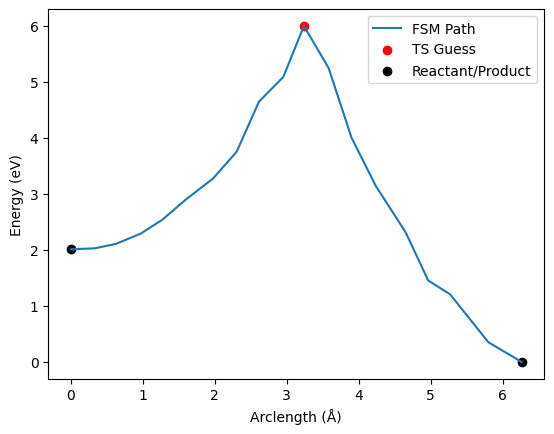

In [10]:
fig, ax = plt.subplots()
ax.plot(s, all_energies, label="FSM Path")
ax.scatter(s[ts_idx], all_energies[ts_idx], color="red", label="TS Guess")
ax.scatter(s[0], all_energies[0], color="black", label="Reactant/Product")
ax.scatter(s[-1], all_energies[-1], color="black")
ax.set_xlabel("Arclength (Å)")
ax.set_ylabel("Energy (eV)")
_ = ax.legend()

In [11]:
def snapshot_row(atoms_list: list[ase.Atoms], labels: list[str] | None = None) -> HTML:
    """Show selected structures."""
    html = []
    for i, atoms in enumerate(atoms_list):
        symbols = atoms.get_chemical_symbols()
        positions = atoms.get_positions()

        xyz_str = f"{len(atoms)}\n\n" + "\n".join(
            f"{sym} {x} {y} {z}" for sym, (x, y, z) in zip(symbols, positions, strict=True)
        )

        view = py3Dmol.view(width=250, height=250)
        view.addModel(xyz_str, "xyz")
        view.setStyle({"stick": {"radius": 0.2}, "sphere": {"radius": 0.6}})
        view.zoomTo()

        # Generate label and viewer together
        label_text = labels[i] if labels else f"Frame {i}"
        viewer_html = view._make_html()

        # Combine label and viewer in a single column
        html.append(
            f"""
<div style='display:flex;flex-direction:column;align-items:center;margin-right:10px'>
    <div style='font-weight:bold;margin-bottom:4px;text-align:center'>{label_text}</div>
    {viewer_html}
</div>"""
        )

    return HTML(f"<div style='display:flex;gap:10px'>{''.join(html)}</div>")


# Example usage
frames_to_show = [all_atoms[0], all_atoms[ts_idx], all_atoms[-1]]
custom_labels = [
    "Reactant<br> Relative Energy: {:.1f} eV".format(all_energies[0]),
    "TS Guess<br> Relative Energy: {:.1f} eV".format(all_energies[ts_idx]),
    "Product<br> Relative Energy: {:.1f} eV".format(all_energies[-1]),
]
snapshot_row(frames_to_show, custom_labels)